# Evaluation and Interpretation
## I. List of Abbreviations
| Abbreviation | Meaning |
|---|---|
| AP | Average precision |
| AUC | Area under the curve |
| Avg | Average |
| IQR | Interquartile range |
| SMOTE | Synthetic minority over-sampling technique |
| VIF | Variance inflation factor |
## II. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import dice_ml
from dice_ml import Dice

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance

from statsmodels.stats.outliers_influence import variance_inflation_factor

import src.data_preparation as dp

# set seaborn theme
custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed"}
sns.set_theme(style="whitegrid", font_scale=0.8, rc=custom)

# display all rows and columns of pandas DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# suppress scientific notation
pd.options.display.float_format = '{:.3f}'.format  # displays three decimals

## 1 General Data Preparation

In [2]:
# load the data
df = pd.read_csv("data/raw/Data for Task 1.csv", index_col="id")

In [3]:
# encode the label numerically
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df["diagnosis"].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [4]:
# reorder the data, so that the label is in the last column
label = df.pop("diagnosis")
df["diagnosis"] = label
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,diagnosis
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,NaN,1
842517,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,NaN,1
84300903,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,NaN,1
84348301,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,NaN,1
84358402,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,NaN,1


In [5]:
# delete the last feature which is unnamed and only contains missing values
df.drop(columns=["Unnamed: 32"], inplace=True)

### 1.1 Data Split

In [6]:
# split the data into features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# split the data into a train set (85%) and a test set (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5, stratify=y)

### 1.2 Metrics

In [7]:
# define a scoring system that will be used to evaluate model performance
scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

## 2 Model Evaluation (Min-Max Scaler)

In [8]:
# create a preprocessing pipeline with the best hyperparameters (see "02_modeling.ipynb")
preprocessing_lr_train_mm = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True))),
    ("log", dp.LogTransformer(transform_all=False)),
    ("scaler", dp.Scaler(method="min_max")),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc_mm, y_train_proc_mm = preprocessing_lr_train_mm.fit_resample(X_train, y_train)
print("Preprocessed the training data.")

# initialize a logistic regression model with the best hyperparameters 
log_reg_mm = LogisticRegression( 
    random_state=5, 
    max_iter=1000,
    solver="saga",
    penalty="l1",
    C=1.624
)

# train the logistic regression model
log_reg_mm.fit(X_train_proc_mm, y_train_proc_mm)
print("Trained the logistic regression model.")

# define a preprocessing pipeline to apply the logistic regression to the unseen test data
preprocessing_lr_test_mm = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_lr_train_mm.named_steps["imputer_adder"]),
    ("log", preprocessing_lr_train_mm.named_steps["log"]),
    ("scaler", preprocessing_lr_train_mm.named_steps["scaler"]),
    ("feature_selector", preprocessing_lr_train_mm.named_steps["feature_selector"])
])

# apply the preprocessing pipeline to the test data
X_test_proc_mm = preprocessing_lr_test_mm.transform(X_test)
print("Preprocessed the test data.")

# predict the labels for the preprocessed test data
y_test_pred_mm = log_reg_mm.predict(X_test_proc_mm)
print("Made predictions for the test data.")

# predict the probabilities for the preprocessed test data
y_test_prob_mm = log_reg_mm.predict_proba(X_test_proc_mm)[:, 1]  # yields the probability for the positive class

Preprocessed the training data.
Trained the logistic regression model.
Preprocessed the test data.
Made predictions for the test data.


### 2.1 Classification Report

In [9]:
# calculate a detailed classification report (Kamath & Liu, 2021, pp. 83-89)
report = classification_report(y_test, y_test_pred_mm, target_names=["Benign", "Malignant"], output_dict=True)

# convert the report into a DataFrame
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Benign,1.000,0.981,0.991,54.000
Malignant,0.970,1.000,0.985,32.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.985,0.991,0.988,86.000
weighted avg,0.989,0.988,0.988,86.000


Observations
* Benign tumors:
    * Precision = 1: All tumors classified as benign are actually benign. There are no tumors classified as benign that are actually malignant.
    * Recall = 0.981: 98.1% of the actually benign tumors were correctly identified as benign. 1.9% of benign tumors were incorrectly predicted as malignant.
    * F1-Score = 0.991: The F1-Score combines precision and recall (Muntean & Militaru, 2023, p. 310) and shows an overall very high performance in the prediction of benign tumors.
* Malignant tumors:
    * Precision = 0.97: 97% of tumors classified as malignant are actually malignant. 3% of the tumors were incorrectly predicted as malignant although they are benign.
    * Recall = 1: The model detects all malignant tumors, which means that no malignant tumors were missed.
    * F1-Score = 0.985: Again, the F1-Score is high and shows that the model is good at detecting malignant tumors without making many mistakes.
* Accuracy = 0.988: Almost 99% of the predictions are correct.
* The unweighted and weighted average for both classes show overall performance values of at least 98%.
* Conclusion: The model shows a very high performance overall. Particularly noteworthy is that it is able to correctly detect all malignant tumors (recall = 1). This is crucial in medical applications, as missing malignant tumors can have serious consequences (World Health Organization, 2024, section "treatment").

### 2.2 Odds Ratios

In [10]:
# create a DataFrame containing the model coefficients
coefficients = pd.DataFrame({
    "feature": X_train_proc_mm.columns,
    "coefficient": log_reg_mm.coef_[0]
})

# sort Dataframe by coefficient values
coefficients = coefficients.sort_values(by="coefficient", ascending=False)

# calculate odds ratios (Szumilas, 2010, p. 227)
coefficients["Odds Ratio"] = np.exp(coefficients["coefficient"])
coefficients

,feature,coefficient,Odds Ratio
1,log_area_worst,22.533,6106090466.018
2,smoothness_worst,8.843,6928.922
0,texture_mean,4.586,98.116


Observations
* The odds ratios of all three features are very high (Chatterjee et al., 2021, p. 3).
* One reason for this could be multicollinearity of the features in the model, as this can lead to unstable parameter estimates (Smith et al., 2014, p. 73; Zabor et al., 2022, p. 276). For this reason, the next step was to examine the multicollinearity of the features using the variance inflation factor (VIF). 

In [11]:
# calculate the VIFs
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_proc_mm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_proc_mm.values, i) for i in range(X_train_proc_mm.shape[1])]
vif_data

,Feature,VIF
0,texture_mean,6.758
1,log_area_worst,8.159
2,smoothness_worst,6.016


Observations
* The VIFs indicate potentially problematic multicollinearity of the features, as all VIF values are above 5 (Akinwande et al., 2015, p. 756).
* The use of standardization instead of min-max scaling of the data was able to reduce the multicollinearity of the features and thus also the extremely high parameter estimates (see sections 4.1 and 4.2). For this reason, the results of the logistic regression model using standardization are discussed below. 

## 3 Model Evaluation (Standard Scaler)
### 3.1 Cross Validation

In [12]:
# perform cross validation for a preprocessing pipeline that uses the standard scaler instead of the min-max scaler
pipeline_standard = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True))),
    ("log", dp.LogTransformer(transform_all=False)),
    ("scaler", dp.Scaler(method="standard")),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5)),
    ("classifier", LogisticRegression(random_state=5, max_iter=1000, solver="saga", penalty="l1", C=1.624))
])

# calculate the F1-scores for each split and the mean F1-score
scores = cross_val_score(pipeline_standard, X_train, y_train, cv=5, scoring="f1")
print("Cross-validation F1-scores:", scores)
print("Mean cross-validation F1-score:", scores.mean())

Cross-validation F1-scores: [0.95774648 0.97222222 0.95652174 0.97297297 0.98591549]
Mean cross-validation F1-score: 0.9690757812313233


Observations
* The F1-scores when using standardization in the data preprocessing pipeline are above 0.95 in every split and thus - like when using of min-max scaling - meet the defined performance criterion.
* The average F1-score is even slightly higher when using standardization than when using min-max scaling (average F1-score: 0.966).

### 3.2 Model Evaluation and Error Analysis

In [13]:
# create a preprocessing pipeline with the best hyperparameters (see "02_modeling.ipynb"), but using standardization instead of min-max scaling
preprocessing_lr_train = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True))),
    ("log", dp.LogTransformer(transform_all=False)),
    ("scaler", dp.Scaler(method="standard")),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc, y_train_proc = preprocessing_lr_train.fit_resample(X_train, y_train)
print("Preprocessed the training data.")

# initialize a logistic regression model with the best hyperparameters 
log_reg = LogisticRegression( 
    random_state=5, 
    max_iter=1000,
    solver="saga",
    penalty="l1",
    C=1.624
)

# train the logistic regression model
log_reg.fit(X_train_proc, y_train_proc)
print("Trained the logistic regression model.")

# define a preprocessing pipeline to apply the logistic regression to the unseen test data using standardization
preprocessing_lr_test = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_lr_train.named_steps["imputer_adder"]),
    ("log", preprocessing_lr_train.named_steps["log"]),
    ("scaler", preprocessing_lr_train.named_steps["scaler"]),
    ("feature_selector", preprocessing_lr_train.named_steps["feature_selector"])
])

# apply the preprocessing pipeline to the test data
X_test_proc = preprocessing_lr_test.transform(X_test)
print("Preprocessed the test data.")

# predict the labels for the preprocessed test data
y_test_pred = log_reg.predict(X_test_proc)
print("Made predictions for the test data.")

# predict the probabilities for the preprocessed test data
y_test_prob = log_reg.predict_proba(X_test_proc)[:, 1]  # yields the probability for the positive class

Preprocessed the training data.
Trained the logistic regression model.
Preprocessed the test data.
Made predictions for the test data.


#### 3.2.1 Classification Report

In [14]:
# calculate a detailed classification report (Kamath & Liu, 2021, pp. 83-89)
report = classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"], output_dict=True)

# convert the report into a DataFrame
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Benign,1.000,0.981,0.991,54.000
Malignant,0.970,1.000,0.985,32.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.985,0.991,0.988,86.000
weighted avg,0.989,0.988,0.988,86.000


Observations
* It is not relevant for the performance of the logistic regression model whether the raw values are preprocessed using the min-max scaler or the standard scaler. The performance is the same in both cases up to at least the third decimal place. 

#### 3.2.2 Discrimination Threshold Tuning

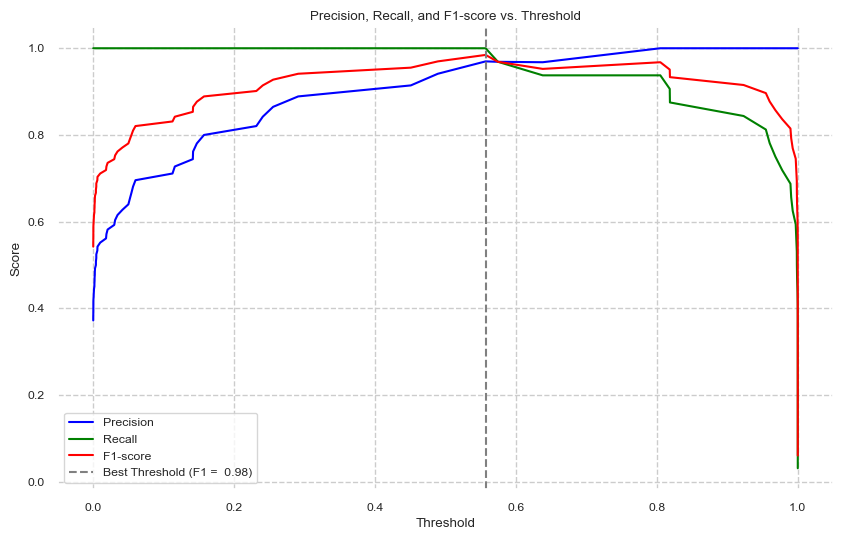

Best Threshold: 0.556942146102245
Best F1-score: 0.9846153846153847


,precision,recall,f1-score,support
Benign,1.000,0.981,0.991,54.000
Malignant,0.970,1.000,0.985,32.000
accuracy,0.988,0.988,0.988,0.988
macro avg,0.985,0.991,0.988,86.000
weighted avg,0.989,0.988,0.988,86.000


In [15]:
# calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

# calculate F1-scores for each threshold
f1_scores = [f1_score(y_test, y_test_prob >= t) for t in thresholds]

# find the best threshold based on the highest F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# plot precision, recall, and F1-score against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.plot(thresholds, f1_scores, label="F1-score", color="red")
plt.axvline(x=best_threshold, color="gray", linestyle="--", label=f"Best Threshold (F1 = {best_f1: 0.2f})")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score vs. Threshold")
plt.legend(loc="best")
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best F1-score: {best_f1}")

# apply the best threshold to make final predictions
y_test_pred_best = (y_test_prob >= best_threshold).astype(int)

# evaluate the model with the best threshold (Kamath & Liu, 2021, pp. 83-89)
report_best = classification_report(y_test, y_test_pred_best, target_names=["Benign", "Malignant"], output_dict=True)

# convert the report into a DataFrame
report_best_df = pd.DataFrame(report_best).transpose()
report_best_df

Observations
* The proposed best threshold (0.56) is slightly above the default threshold of 0.5.
* However, this does not change the performance values up to and including the third decimal place in the classification report. The threshold is therefore left at 0.5. The fact that the probability of malignancy makes a different prediction above 0.5 than below 0.5 is presumably easier to explain than a change in the prediction at 0.56. 

#### 3.2.3 Confusion Matrix

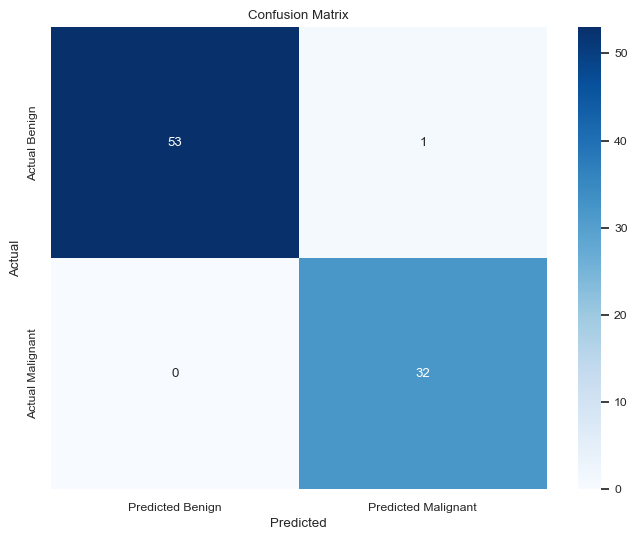

In [16]:
# display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# create a heatmap to format the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Benign", "Predicted Malignant"], yticklabels=["Actual Benign", "Actual Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Observations
* All predictions of the model except one are correct.
* The incorrect prediction is a false-positive prediction: a benign tumor was incorrectly classified as malignant. In a medical context, such errors are often less fatal than false-negative predictions (World Health Organization, 2024).

#### 3.2.4 Analysis of Prediction Errors

,texture_mean,log_area_worst,smoothness_worst,classification,probability
42,-1.927,0.300,0.961,false-positive,0.638



Mean probabilities per group:


,classification,probability
0,correct-benign,0.062
1,correct-malignant,0.948
2,false-positive,0.638


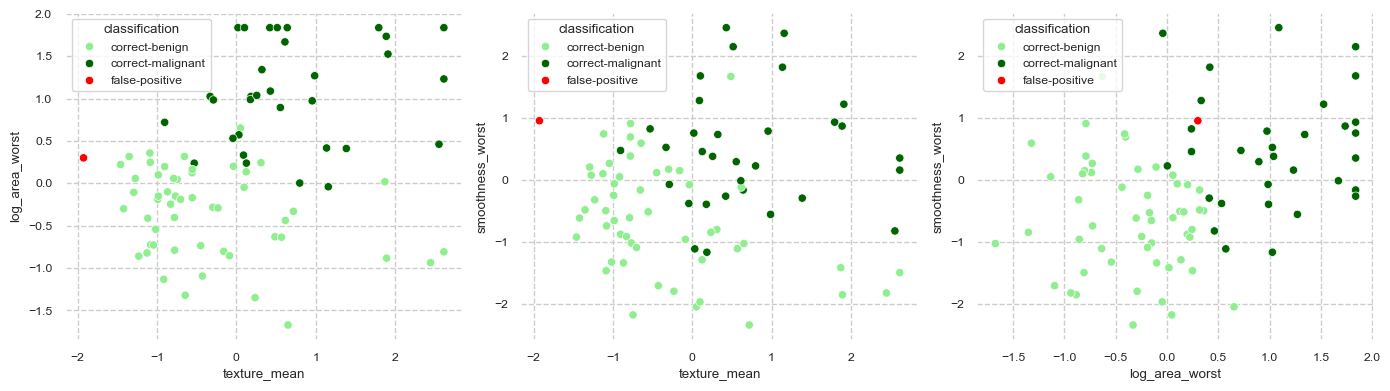

In [17]:
# create a copy of the preprocessed feature values
X_error = X_test_proc.copy()

# add an error column to the DataFrame which classifies the predictions as either correct-benign, correct-malignant, false-positive, or false-negative
X_error["classification"] = ["correct-benign" if true == pred and true == 0 else
                             "correct-malignant" if true == pred and true == 1 else
                             "false-positive" if true != pred and true == 0 else
                             "false-negative" for true, pred in zip(y_test, y_test_pred)]

# add the predicted probabilities to the DataFrame
X_error["probability"] = y_test_prob

# display rows with "false-positive" errors
false_positive = X_error[X_error["classification"] == "false-positive"]
display(false_positive)

# display mean probabilities in each group
print("\nMean probabilities per group:")
error_prob_means = X_error.groupby("classification")["probability"].mean().reset_index()
display(error_prob_means)

# get the list of feature names from the processed test set
features = X_test_proc.columns.tolist()

# plot scatter plots
plt.figure(figsize=(14, 4))
palette={"correct-benign": "lightgreen", "correct-malignant": "darkgreen", "false-positive": "red", "false_negative": "orange"}

# scatter plot for feature 0 vs feature 1
plt.subplot(1, 3, 1)
sns.scatterplot(data=X_error, x=features[0], y=features[1], hue="classification", palette=palette)

# scatter plot for feature 0 vs feature 2
plt.subplot(1, 3, 2)
sns.scatterplot(data=X_error, x=features[0], y=features[2], hue="classification", palette=palette)

# scatter plot for feature 1 vs feature 2
plt.subplot(1, 3, 3)
sns.scatterplot(data=X_error, x=features[1], y=features[2], hue="classification", palette=palette)

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Observations
* In particular, the scatterplot displaying `smoothness_worst` and `log_area_worst` shows that the misclassified tumor is more similar to the values of malignant tumors than to the values of benign tumors.
* The probability of malignancy (63.8%) is comparatively low. On average, malignant tumors are correctly predicted with a probability of 94.8%. Accordingly, experts should not rely on the predictions of the model for probabilities that are close to the threshold of 50%. 

#### 3.2.5 ROC Curve and AUC

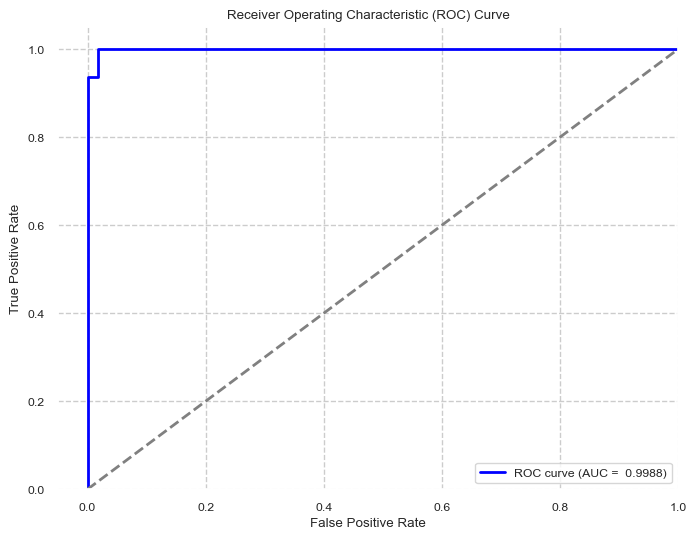

In [18]:
# calculate the receiver operating characteristic (ROC) curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)

# calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc: 0.4f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.savefig("figures/ROC-curve.pdf")
plt.savefig("figures/ROC-curve.png")
plt.show()

Observations
* The ROC curve is very close to the upper left corner, which indicates a high quality of the model (Kamath & Liu, 2021, p. 86). The true positive rate is high while the false positive rate is simultaneously low.
* The AUC value of the model is also very high at 99.88%. This indicates a high generalizability of the model (Kamath & Liu, 2021, p. 86). 

#### 3.2.6 Precision-Recall Curve

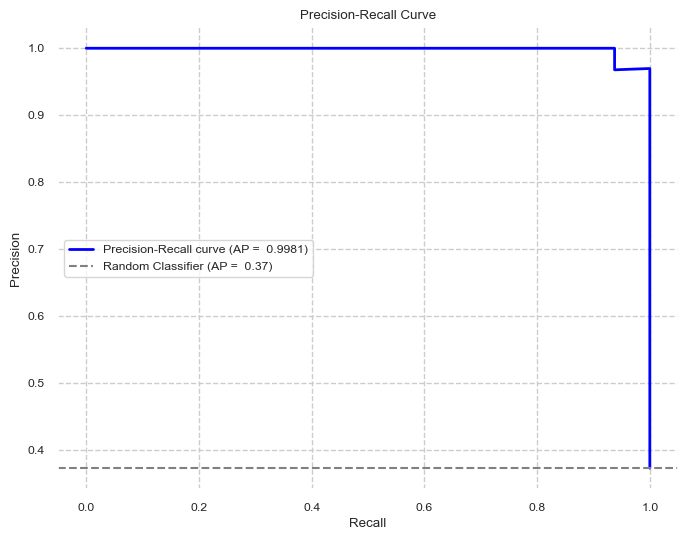

In [19]:
# calculate the average precision score
avg_precision = average_precision_score(y_test, y_test_prob)

# calculate the proportion of positive instances in the dataset
positive_ratio = np.sum(y_test) / len(y_test)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"Precision-Recall curve (AP = {avg_precision: 0.4f})")
plt.axhline(y=positive_ratio, color="gray", linestyle="--", label=f"Random Classifier (AP = {positive_ratio: 0.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.savefig("figures/precision_recall_curve.png")
plt.savefig("figures/precision_recall_curve.pdf")
plt.show()

Observations
* The area under the precision recall curve - the average precision (AP) - is very high, which also reflects the quality of the model, especially when considering an imbalanced dataset (Kamath & Liu, 2021, p. 87). 

### 4 Model Interpretation
#### 4.1 Feature Coefficients and Feature Importance

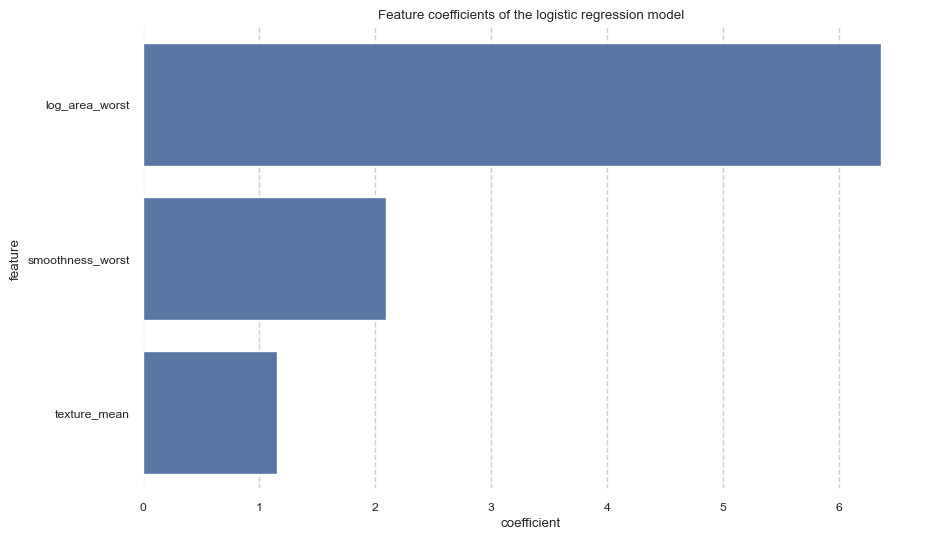

In [20]:
# create a DataFrame containing the model coefficients
coefficients = pd.DataFrame({
    "feature": X_train_proc.columns,
    "coefficient": log_reg.coef_[0]
})

# sort Dataframe by coefficient values
coefficients = coefficients.sort_values(by="coefficient", ascending=False)

# visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="coefficient", y="feature", data=coefficients)
plt.title("Feature coefficients of the logistic regression model")
plt.show()

Observations
* All three feature coefficients are positive, so it can be assumed that an increase in the three features increases the probability of the model classifying the tumor as malignant (Molnar, 2019, p. 58). 
* The feature `log_area_worst` has by far the largest coefficient and therefore has the greatest influence on the model prediction. An increase in this value greatly increases the probability that the tumor will be predicted as malignant.
* The influence of the features `smoothness_worst` and `texture_mean` on the model prediction is significantly lower than the influence of `log_area_worst`, but nonetheless positive. 

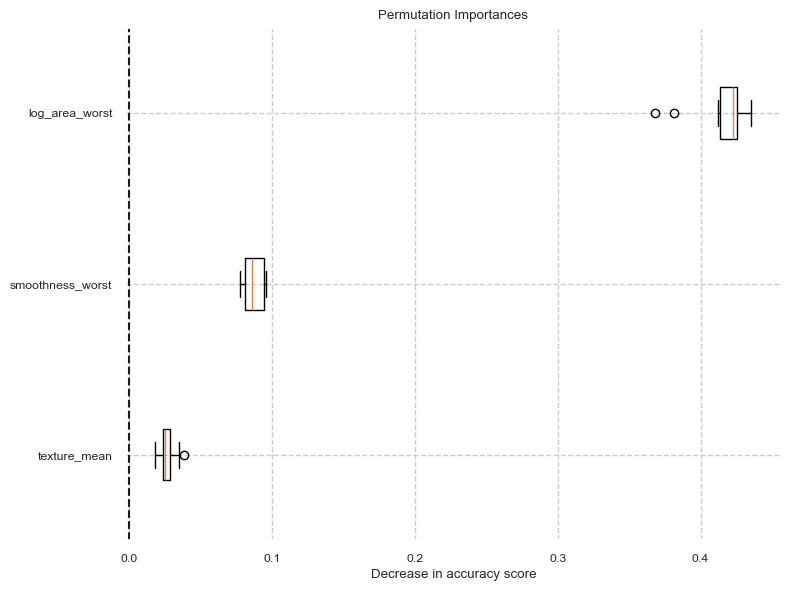

,features,importance,importance_std
1,log_area_worst,0.414,0.021
2,smoothness_worst,0.087,0.007
0,texture_mean,0.026,0.006


In [21]:
# calculate the permutation importance on the train set
lr_imp = permutation_importance(log_reg, X_train_proc, y_train_proc, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results 
lr_imp_df = dp.display_permutation_importance(lr_imp, X_train_proc)
lr_imp_df

Observations
* The calculation of the model-agnostic feature importances shows the same pattern as when looking at the feature coefficients: `log_area_worst` contributes the most to the prediction accuracy. When the values of this feature are permuted, the accuracy of the model on the training set decreases by 0.41.
* In contrast, permutation of the `texture_mean` values decreases the model accuracy by only 0.03.   

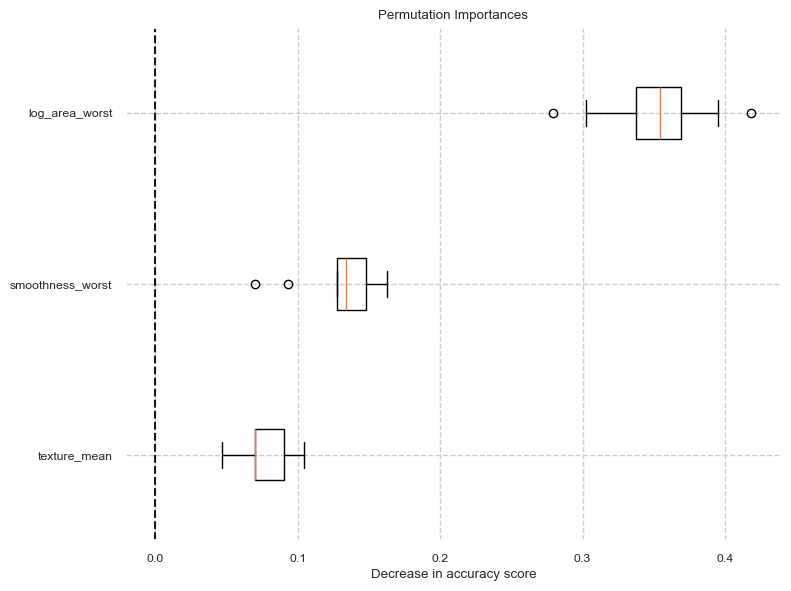

,features,importance,importance_std
1,log_area_worst,0.351,0.039
2,smoothness_worst,0.129,0.027
0,texture_mean,0.076,0.017


In [22]:
# calculate the permutation importance on the test set
lr_imp = permutation_importance(log_reg, X_test_proc, y_test, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results 
lr_imp_df = dp.display_permutation_importance(lr_imp, X_test_proc)
lr_imp_df

Observations
* When comparing the feature importances calculated based on the training set with those calculated based on the test set, the ranking of the features in terms of importance remains the same.
* However, the absolute importance of the features changes: On the test set, a permutation of `log_area_worst` leads to a decrease in model accuracy of 35.1%, compared to 41.4% on the training set.
* In contrast, the importance of the other two features is higher on the test set than on the training set. 

#### 4.2 Odds Ratios

In [23]:
# calculate odds ratios (Szumilas, 2010, p. 227)
coefficients["Odds Ratio"] = np.exp(coefficients["coefficient"])
coefficients

,feature,coefficient,Odds Ratio
1,log_area_worst,6.367,582.557
2,smoothness_worst,2.098,8.151
0,texture_mean,1.157,3.180


Observations
* The odds ratios of the two features `log_area_worst` and `smoothness_worst` can still be described as large (Chatterjee et al., 2021, p. 3), but they are now considerably smaller than when using min-max scaling.
* The higher the values in the three variables, the higher the probability for the tumors to be malignant. For example, the probability that the tumor is malignant is 8.151 times higher with a one-unit increase in `smoothness_worst` than before the increase (Molnar, 2019, p. 58). 

In [24]:
# calculate the VIFs
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_proc.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_proc.values, i) for i in range(X_train_proc.shape[1])]
vif_data

,Feature,VIF
0,texture_mean,1.148
1,log_area_worst,1.184
2,smoothness_worst,1.041


Observations
* Similar to the odds ratios, the VIFs of the features are now also significantly smaller than when using min-max scaling.
* According to Akinwande et al. (2015, p. 756), there is no problematic multicollinearity of the features and thus the parameter estimates of the logistic regression model should be relatively stable (Smith et al., 2014, p. 73; Zabor et al., 2022, p. 276).  

#### 4.3 Prediction Probability Quantiles

,total_count,benign_count,malignant_count,benign_percentage,malignant_percentage,proba_range
quantile,,,,,,
0,9,9,0,100.000,0.000,"(0.0, 0.0]"
1,9,9,0,100.000,0.000,"(0.0, 0.002]"
2,8,8,0,100.000,0.000,"(0.002, 0.005]"
3,9,9,0,100.000,0.000,"(0.005, 0.035]"
4,8,8,0,100.000,0.000,"(0.035, 0.129]"
5,9,9,0,100.000,0.000,"(0.129, 0.451]"
6,8,2,6,25.000,75.000,"(0.451, 0.939]"
7,9,0,9,0.000,100.000,"(0.939, 0.998]"
8,8,0,8,0.000,100.000,"(0.998, 1.0]"


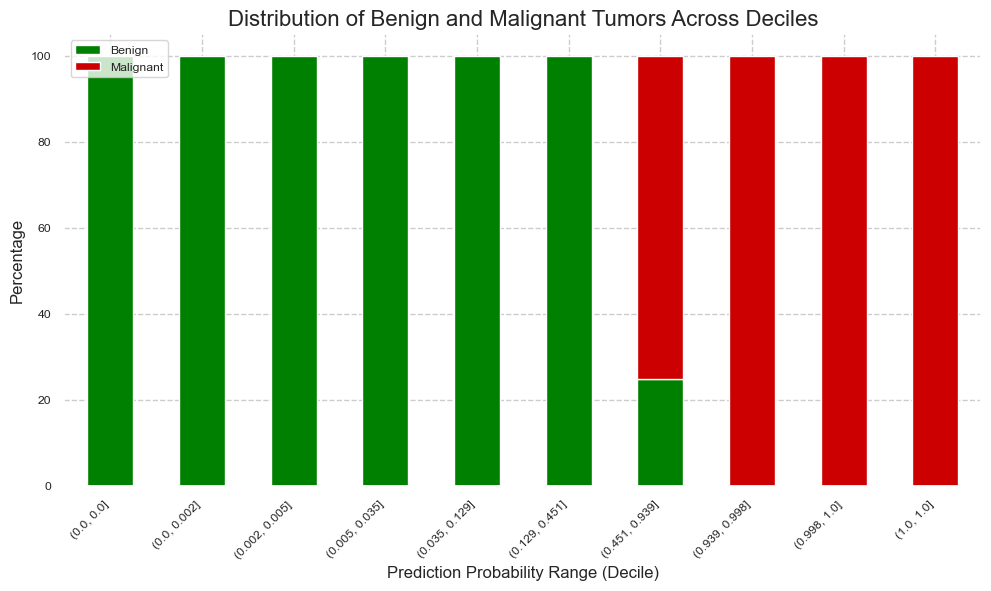

In [25]:
# split and compare quantiles (Agarwal & Mishra, 2021, p. 52)
# create a DataFrame with actual labels and predicted probabilities
df_prob = pd.DataFrame({"y_true": y_test, "y_proba": y_test_prob})

# create deciles based on prediction probabilities
df_prob["quantile"], quantile_bins = pd.qcut(df_prob["y_proba"], 10, labels=False, retbins=True)

# round quantile bins to 3 decimals
quantile_bins = np.round(quantile_bins, 3)

# calculate the ratio of positive and negative classes in each decile
quantile_analysis = df_prob.groupby("quantile", group_keys=False).apply(lambda x: pd.Series({
    "total_count": len(x),
    "benign_count": (x["y_true"] == 0).sum(),  # benign (0)
    "malignant_count": (x["y_true"] == 1).sum()  # malignant (1)
})).reset_index()

# drop the "quantile" column from the index
quantile_analysis.set_index("quantile", inplace=True)

# calculate the percentage of benign and malignant tumors in each decile
quantile_analysis["benign_percentage"] = quantile_analysis["benign_count"] / quantile_analysis["total_count"] * 100
quantile_analysis["malignant_percentage"] = quantile_analysis["malignant_count"] / quantile_analysis["total_count"] * 100

# add probability ranges (thresholds) of the deciles
quantile_analysis["proba_range"] = pd.IntervalIndex.from_breaks(quantile_bins).astype(str)

display(quantile_analysis)

# visualize distribution in a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
red = (204/255, 0, 0, 1)
quantile_analysis[["benign_percentage", "malignant_percentage"]].plot(kind="bar", stacked=True, ax=ax, color=["green", red])

ax.set_xticklabels(quantile_analysis["proba_range"], rotation=45, ha="right")
plt.title("Distribution of Benign and Malignant Tumors Across Deciles", fontsize=16)
plt.xlabel("Prediction Probability Range (Decile)", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Benign", "Malignant"], loc="upper left")
plt.tight_layout()
plt.show()

Observations
* Deciles 0 bs 5 (probability 0 to 0.451): Benign tumors (green) dominate, showing that the model correctly classifies mainly benign tumors as such for prediction probabilities below 0.445. At low probabilities, the predictions show a low probability of malignancy, which is consistent with the high prevalence of benign tumors in these deciles.
* Decile 6 (probability 0.451 to 0.939): A mixture of benign and malignant tumors (25% benign, 75% malignant) is visible. This is the threshold at which the model predicts both benign and malignant tumors. In this probability range, the model could possibly have difficulties. 
* Decile 7 to 9 (probability 0.939 to 1.0): Malignant tumors (red) dominate, showing that the model correctly classifies mainly malignant tumors as such in this range. This is consistent with expectation, as high probabilities indicate higher model confidence with respect to malignancy, which is confirmed by the predominance of malignant tumors in these deciles.  

In [26]:
# display the exact probabilities in decile 6
decile_6 = df_prob[df_prob["quantile"] == 6].reset_index()
display(decile_6.sort_values(by="y_proba"))

,id,y_true,y_proba,quantile
7,8915,0,0.489,6
4,889403,1,0.557,6
6,91979701,1,0.574,6
3,912600,0,0.638,6
5,91594602,1,0.805,6
2,862548,1,0.818,6
0,886452,1,0.819,6
1,862717,1,0.923,6


Observations
* The display of decile 6 shows that experts should not rely completely on the model's predictions, especially for probabilities in the range of 0.45 to 0.7. 

#### 4.4 Counterfactual Explanations

In [27]:
# generate counterfactual explanations (Molnar, 2019, pp. 191-193)
train_data = X_train_proc.copy()
train_data["target"] = y_train_proc

# define continuous features
continuous_features = X_train_proc.columns.tolist()

# create a data object for DiCE
dice_data = dice_ml.Data(dataframe=train_data,
                         continuous_features=continuous_features,
                         outcome_name="target")

# define the DiCE model object for the logistic regression
dice_model = dice_ml.Model(model=log_reg, backend="sklearn")

# initialize the DiCE explainer
dice = Dice(dice_data, dice_model)

##### Counterfactual Explanations for the First Instance

In [28]:
# select the first instance from the test set to generate counterfactual explanations
first_instance = pd.DataFrame(X_test_proc.iloc[0]).transpose()

# generate 5 counterfactuals that change the prediction to the opposite class varying only one feature
df_cfs, test_instance = dp.get_counterfactuals(dice, first_instance, total_cfs=5)

# display the results
print("Instance to explain:")
display(test_instance)

print("\nGenerated counterfactuals:")
df_cfs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No counterfactuals found when only varying texture_mean


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.49it/s]


Diverse Counterfactuals found! total time taken: 00 min 00 sec


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.52it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec
Instance to explain:


,texture_mean,log_area_worst,smoothness_worst,target
0,1.895,-0.884,-1.847,0



Generated counterfactuals:


,texture_mean,log_area_worst,smoothness_worst,target,probability,feature_varied
0,1.895,1.794,-1.847,1,1.000,log_area_worst
1,1.895,0.522,-1.847,1,0.625,log_area_worst
2,1.895,0.837,-1.847,1,0.925,log_area_worst
3,1.895,0.994,-1.847,1,0.971,log_area_worst
4,1.895,0.485,-1.847,1,0.568,log_area_worst
5,1.895,-0.884,2.566,1,0.694,smoothness_worst
6,1.895,-0.884,2.401,1,0.616,smoothness_worst
7,1.895,-0.884,2.449,1,0.639,smoothness_worst
8,1.895,-0.884,2.294,1,0.561,smoothness_worst
9,1.895,-0.884,2.461,1,0.645,smoothness_worst


Observations
* The first instance of the test set was originally predicted to be benign. 
* For the first instance, it was not possible to change the prediction based solely on the variation of `texture_mean`. The prediction only changed with a modification of `smoothness_worst` or `log_area_worst`.
* A moderate change of `log_area_worst` to positive (that is, an above-average log-transformed tumor size) can change the prediction of the model for the first instance to malignant. The higher the `log_area_worst`, the more confident the model is in its prediction.
* Strong changes in `smoothness_worst` (from almost two standard deviations below the mean to more than two standard deviations above the mean) lead to a change in the model prediction from benign to malignant, but with comparatively low confidence.
* This confirms the observed feature importances: `Log_area_worst` has the strongest impact on model predictions, followed by `smoothness_worst` and `texture_mean`. 

##### Counterfactual Explanations for the False Positive Prediction

In [29]:
# select the false positive from the test set to generate counterfactual explanations
false_positive_df = false_positive[X_test_proc.columns]

# generate 5 counterfactuals that change the prediction to the opposite class varying only one feature
df_cfs_fp, test_instance_fp = dp.get_counterfactuals(dice, false_positive_df, total_cfs=5)

# display the results
print("Instance to explain:")
display(test_instance_fp)

print("\nGenerated counterfactuals:")
df_cfs_fp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No counterfactuals found when only varying texture_mean


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.53it/s]


Diverse Counterfactuals found! total time taken: 00 min 00 sec


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.53it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec
Instance to explain:


,texture_mean,log_area_worst,smoothness_worst,target
0,-1.927,0.300,0.961,1



Generated counterfactuals:


,texture_mean,log_area_worst,smoothness_worst,target,probability,feature_varied
0,-1.927,-1.480,0.961,0,0.000,log_area_worst
1,-1.927,-0.356,0.961,0,0.026,log_area_worst
2,-1.927,-1.651,0.961,0,0.000,log_area_worst
3,-1.927,0.009,0.961,0,0.217,log_area_worst
4,-1.927,-2.530,0.961,0,0.000,log_area_worst
5,-1.927,0.300,-1.948,0,0.004,smoothness_worst
6,-1.927,0.300,-0.760,0,0.045,smoothness_worst
7,-1.927,0.300,-2.078,0,0.003,smoothness_worst
8,-1.927,0.300,-0.325,0,0.106,smoothness_worst
9,-1.927,0.300,-0.637,0,0.058,smoothness_worst


Observations
* The case to be explained is the case that was incorrectly predicted as malignant.
* For this case, it was also not possible to change the prediction from malignant to benign using only a variation in `texture_mean`.
* A small reduction in `log_area_worst` from 0.3 to 0.009 would have been sufficient to change the prediction from malignant to benign with relatively high confidence that the tumor was benign (21.7% probability of malignancy).
* Even a moderate change in `smoothness_worst` would have changed the model prediction from malignant to benign.
* Accordingly, for this instance, the incorrect prediction was probably caused by the slightly above average `log_area_worst` and the slightly above average `smoothness_worst`.    

## III. References
Agarwal, S., & Mishra, S. (2021). _Responsible AI: Implementing ethical and unbiased algorithms._ Springer. https://doi.org/10.1007/978-3-030-76860-7

Akinwande, M. O., Dikko, H. G., & Samson, A. (2015). Variance inflation factor: As a condition for the inclusion of suppressor variable(s) in regression analysis. _Open Journal of Statistics_, _5_, 754–767. https://doi.org/10.4236/ojs.2015.57075

Chatterjee, A., Woodruff, H., Wu, G., & Lambin, P. (2021). Limitations of only reporting the odds ratio in the age of precision medicine: A deterministic simulation study. _Frontiers in Medicine_, _8_, Article 640854. https://doi.org/10.3389/fmed.2021.640854

Kamath, U., & Liu, J. (2021). _Explainable artificial intelligence: An introduction to interpretable machine learning_ (1st ed.). Springer. https://doi.org/10.1007/978-3-030-83356-5

Molnar, C. (2019). _Interpretable machine learning: A guide for making black box models explainable._ Leanpub. http://leanpub.com/interpretable-machine-learning 

Muntean, M., & Militaru, F.‑D. (2023). Metrics for Evaluating Classification Algorithms. In C. Ciurea, P. Pocatilu, & F. G. Filip (Eds.), _Smart Innovation, Systems and Technologies: Vol. 321. Education, research and business technologies: Proceedings of 21st International Conference on Informatics in Economy (IE 2022)_ (pp. 307–317). Springer. https://doi.org/10.1007/978-981-19-6755-9_24

Smith, M., Li, L., Augustyn, M., Kurmi, O., Chen, J., Collins, R., Guo, Y., Han, Y., Qin, J., Xu, G., Wang, J., Bian, Z., Zhou, G., Peto, R., & Chen, Z. (2014). Prevalence and correlates of airflow obstruction in ∼317000 never-smokers in China. _European Respiratory Journal_, _44_, 66–77. https://doi.org/10.1183/09031936.00152413

Szumilas, M. (2010). Explaining odds ratios. _Journal of the Canadian Academy of Child and Adolescent Psychiatry_, _19_(3), 227–229. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/

World Health Organization. (2024, March 13). _Breast cancer._ https://www.who.int/news-room/fact-sheets/detail/breast-cancer

Zabor, E. C., Reddy, C. A., Tendulkar, R. D., & Patil, S. (2022). Logistic regression in clinical studies. _International Journal of Radiation Oncology, Biology, Physics_, _112_(2), 271–277. https://doi.org/10.1016/j.ijrobp.2021.08.007